In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gigan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_url = "https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv"
test_url = "https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv"

train_df = pd.read_csv(train_url, names=["label", "title", "text"])
test_df = pd.read_csv(test_url, names=["label", "title", "text"])

X_train, X_val, y_train, y_val = train_test_split(train_df["title"] + " " + train_df["text"], train_df["label"], test_size=0.2, random_state=42)
X_test, y_test = test_df["title"] + " " + test_df["text"], test_df["label"]

In [4]:
train_df

,label,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [5]:
def tokenize(text):
    return word_tokenize(text.lower())

all_text = " ".join(X_train)
tokens = tokenize(all_text)
vocab = Counter(tokens)
vocab_size = len(vocab) + 2 
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(vocab.most_common())}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1
idx2word = {idx: word for word, idx in word2idx.items()}

def text_to_indices(text):
    return [word2idx.get(word, word2idx['<UNK>']) for word in tokenize(text)]

In [6]:
example_text = X_val.iloc[0] 
print("Текст:", example_text)

example_indices = text_to_indices(example_text)
print("Токены:", example_indices)

example_words = [idx2word.get(idx, '<UNK>') for idx in example_indices]
print("Слова:", example_words)

Текст: BBC set for major shake-up, claims newspaper London - The British Broadcasting Corporation, the world #39;s biggest public broadcaster, is to cut almost a quarter of its 28 000-strong workforce, in the biggest shake-up in its 82-year history, The Times newspaper in London said on Monday.
Токены: [2649, 169, 12, 210, 7964, 3, 583, 1342, 240, 17, 2, 197, 5299, 1829, 3, 2, 60, 13, 14, 9, 18, 367, 383, 7613, 3, 25, 5, 282, 681, 6, 267, 7, 26, 1621, 1, 4181, 3, 8, 2, 367, 7964, 8, 26, 59567, 595, 3, 2, 607, 1342, 8, 240, 31, 11, 64, 4]
Слова: ['bbc', 'set', 'for', 'major', 'shake-up', ',', 'claims', 'newspaper', 'london', '-', 'the', 'british', 'broadcasting', 'corporation', ',', 'the', 'world', '#', '39', ';', 's', 'biggest', 'public', 'broadcaster', ',', 'is', 'to', 'cut', 'almost', 'a', 'quarter', 'of', 'its', '28', '<UNK>', 'workforce', ',', 'in', 'the', 'biggest', 'shake-up', 'in', 'its', '82-year', 'history', ',', 'the', 'times', 'newspaper', 'in', 'london', 'said', 'on', 'mond

In [7]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len=50):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx] - 1  
        text_indices = text_to_indices(text)
        text_indices = text_indices[:self.max_len] + [0] * (self.max_len - len(text_indices)) 
        return torch.tensor(text_indices).to(device), torch.tensor(label).to(device)


train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
for texts, labels in train_loader:
    words = [idx2word[idx.item()] for idx in texts[0] if idx.item() != word2idx['<PAD>']]  
    reconstructed_text = " ".join(words)
    
    print("Токены:", texts[0])  
    print("Текст:", reconstructed_text)
    print("Метка:", labels[0].item())
    break  

Токены: tensor([ 6972,   231,  1472,  1312,     2,   120,    93,   100,    68,    45,
          679,    23,     6,   632,   110,    12, 18567,  1160,    20,   848,
        24108, 34002, 20770,    28,    35,   648,  5751,     4,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
Текст: cavs get needed rest the off week could not have come at a better time for 13th-ranked virginia with quarterback marques hagans hobbled by an injured hip .
Метка: 1


In [9]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        output = self.fc(hidden[-1]) 
        return output

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])  
        return output

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, output_size, num_filters=100):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.conv1 = nn.Conv1d(in_channels=embed_size, out_channels=num_filters, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=embed_size, out_channels=num_filters, kernel_size=4)
        self.conv3 = nn.Conv1d(in_channels=embed_size, out_channels=num_filters, kernel_size=5)
        
        self.fc = nn.Linear(num_filters * 3, output_size)

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)  
        
        conv1_out = F.relu(self.conv1(embedded))
        conv2_out = F.relu(self.conv2(embedded))
        conv3_out = F.relu(self.conv3(embedded))

        conv1_out = F.max_pool1d(conv1_out, conv1_out.size(2)).squeeze(2)  
        conv2_out = F.max_pool1d(conv2_out, conv2_out.size(2)).squeeze(2)
        conv3_out = F.max_pool1d(conv3_out, conv3_out.size(2)).squeeze(2)

        combined = torch.cat((conv1_out, conv2_out, conv3_out), 1)
        output = self.fc(combined)
        
        return output


In [12]:
embed_size = 100
hidden_size = 128
output_size = 4 

models = {
    "GRU": GRUModel(vocab_size, embed_size, hidden_size, output_size).to(device),
    "LSTM": LSTMModel(vocab_size, embed_size, hidden_size, output_size).to(device),
    "CNN": CNNModel(vocab_size, embed_size, output_size).to(device)
}

In [13]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct_predictions, total_predictions = 0, 0, 0

        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}", unit="batch") as tepoch:
            for texts, labels in tepoch:
                optimizer.zero_grad()
                outputs = model(texts)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)

                tepoch.set_postfix(
                    loss=total_loss / len(tepoch),
                    accuracy=correct_predictions / total_predictions
                )

        train_loss_history.append(total_loss / len(train_loader))
        train_acc_history.append(correct_predictions / total_predictions)

        model.eval()
        val_loss, val_correct_predictions, val_total_predictions = 0, 0, 0

        with tqdm(val_loader, desc=f"Evaluting Epoch {epoch + 1}/{epochs}", unit="batch") as tepoch:
            with torch.no_grad():
                for texts, labels in tepoch:
                    outputs = model(texts)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_predictions += (predicted == labels).sum().item()
                    val_total_predictions += labels.size(0)

                    tepoch.set_postfix(
                        val_loss=val_loss / len(tepoch),
                        val_accuracy=val_correct_predictions / val_total_predictions
                    )

        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct_predictions / val_total_predictions)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def evaluate_model(model, test_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [14]:
histories = {}
test_accuracies = {}

for model_name, model in models.items():
    print(model_name)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)
    histories[model_name] = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    }
    test_accuracy = evaluate_model(model, test_loader)
    test_accuracies[model_name] = test_accuracy
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")

GRU


Evaluting Epoch 10/10: 100%|██████████| 375/375 [00:09<00:00, 37.89batch/s, val_accuracy=0.904, val_loss=0.539]


Test Accuracy for GRU: 0.9001
LSTM


Evaluting Epoch 10/10: 100%|██████████| 375/375 [00:13<00:00, 28.82batch/s, val_accuracy=0.9, val_loss=0.486]  


Test Accuracy for LSTM: 0.8983
CNN


Evaluting Epoch 10/10: 100%|██████████| 375/375 [00:09<00:00, 37.91batch/s, val_accuracy=0.895, val_loss=0.604]


Test Accuracy for CNN: 0.8928


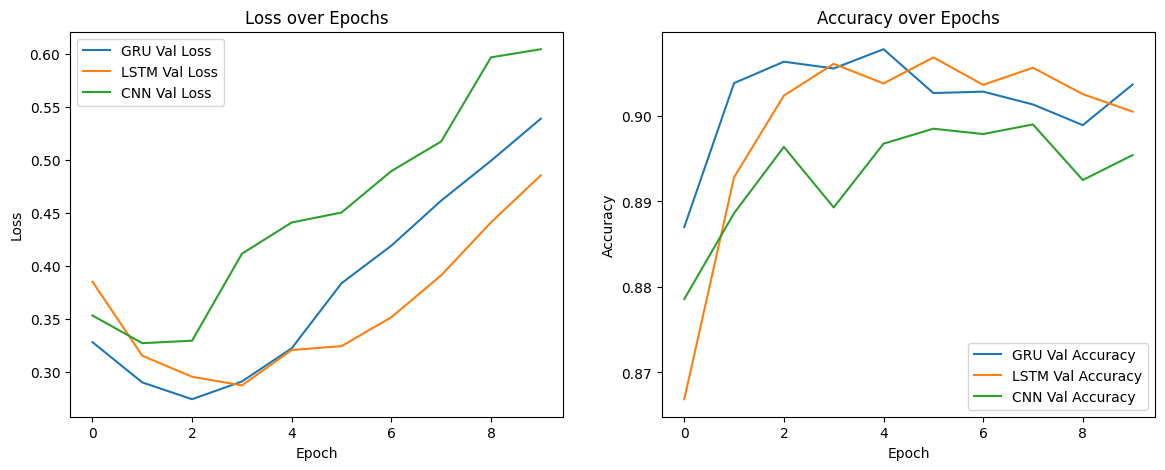

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for model_name, history in histories.items():
    #ax1.plot(history["train_loss"], label=f'{model_name} Train Loss')
    ax1.plot(history["val_loss"], label=f'{model_name} Val Loss')
ax1.set_title("Loss over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

for model_name, history in histories.items():
    #ax2.plot(history["train_acc"], label=f'{model_name} Train Accuracy')
    ax2.plot(history["val_acc"], label=f'{model_name} Val Accuracy')
ax2.set_title("Accuracy over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()